In [1]:
# Configuration — pick any crop growth file and weather year to inspect
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

GROWTH_DIR = Path("../crops/crop_daily_growth")

CROP = "cucumber"
PLANTING = "apr01"
CONDITION = "openfield"
WEATHER_YEAR = 2015

FNAME = f"{CROP}_{PLANTING}_{CONDITION}-research.csv"
FPATH = GROWTH_DIR / CROP / FNAME
print(f"File: {FPATH}")

File: ../crops/crop_daily_growth/cucumber/cucumber_apr01_openfield-research.csv


In [2]:
# Load data and filter to selected weather year
df_all = pd.read_csv(FPATH, comment="#", parse_dates=["date"])
df = df_all[df_all["weather_year"] == WEATHER_YEAR].copy()

policies = df["irrigation_policy"].unique().tolist()
season_len = df["day_of_season"].max()
print(f"Weather year {WEATHER_YEAR} | {len(policies)} policies: {policies}")
print(f"Season length: {season_len} days | Rows: {len(df)}")

Weather year 2015 | 5 policies: ['full_eto', 'optimal_deficit', 'deficit_80', 'deficit_60', 'rainfed']
Season length: 85 days | Rows: 425


In [3]:
# Consistent colors per irrigation policy
POLICY_COLORS = {
    "full_eto": "#1f77b4",
    "optimal_deficit": "#2ca02c",
    "deficit_80": "#ff7f0e",
    "deficit_60": "#d62728",
    "rainfed": "#9467bd",
}

def color_for(policy):
    return POLICY_COLORS.get(policy, "#333333")

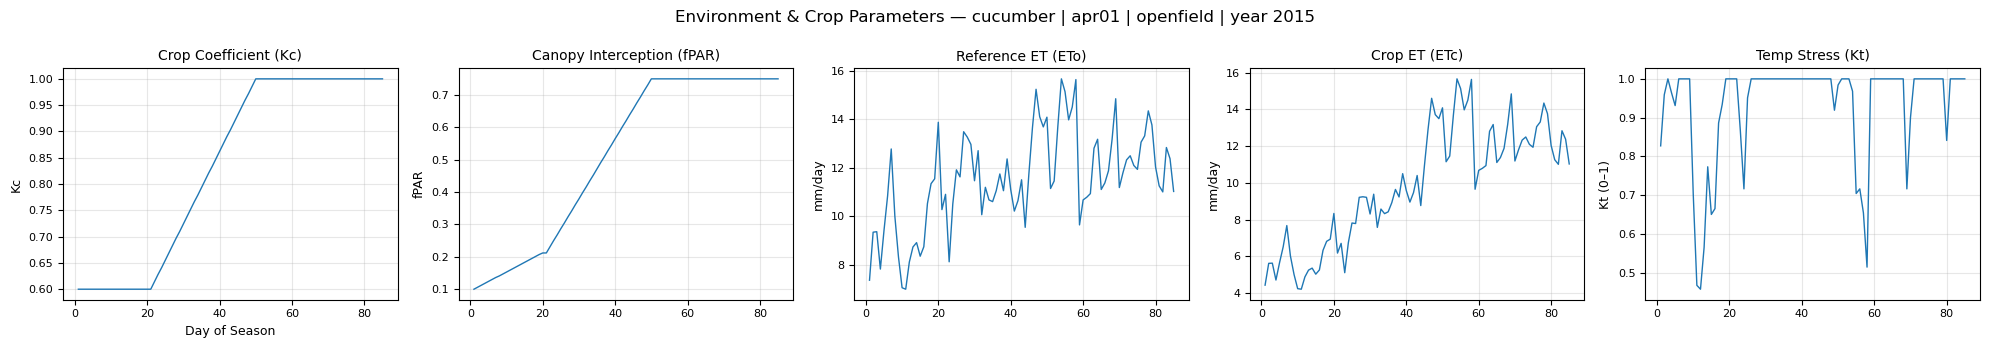

In [4]:
# Row 1 — policy-independent variables (single line, full_eto reference)
ROW1_VARS = [
    ("kc",                "Kc",          "Crop Coefficient (Kc)"),
    ("fpar",              "fPAR",        "Canopy Interception (fPAR)"),
    ("eto_mm",            "mm/day",      "Reference ET (ETo)"),
    ("etc_mm",            "mm/day",      "Crop ET (ETc)"),
    ("temp_stress_coeff", "Kt (0–1)",    "Temp Stress (Kt)"),
]

ref = df[df["irrigation_policy"] == "full_eto"]

fig, axes = plt.subplots(1, len(ROW1_VARS), figsize=(20, 3.5), sharex=True)
for ax, (col, ylabel, title) in zip(axes, ROW1_VARS):
    ax.plot(ref["day_of_season"], ref[col], color="#1f77b4", linewidth=1.0)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.set_title(title, fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

axes[0].set_xlabel("Day of Season", fontsize=9)
fig.suptitle(
    f"Environment & Crop Parameters — {CROP} | {PLANTING} | {CONDITION} | year {WEATHER_YEAR}",
    fontsize=12,
)
plt.tight_layout()
plt.show()

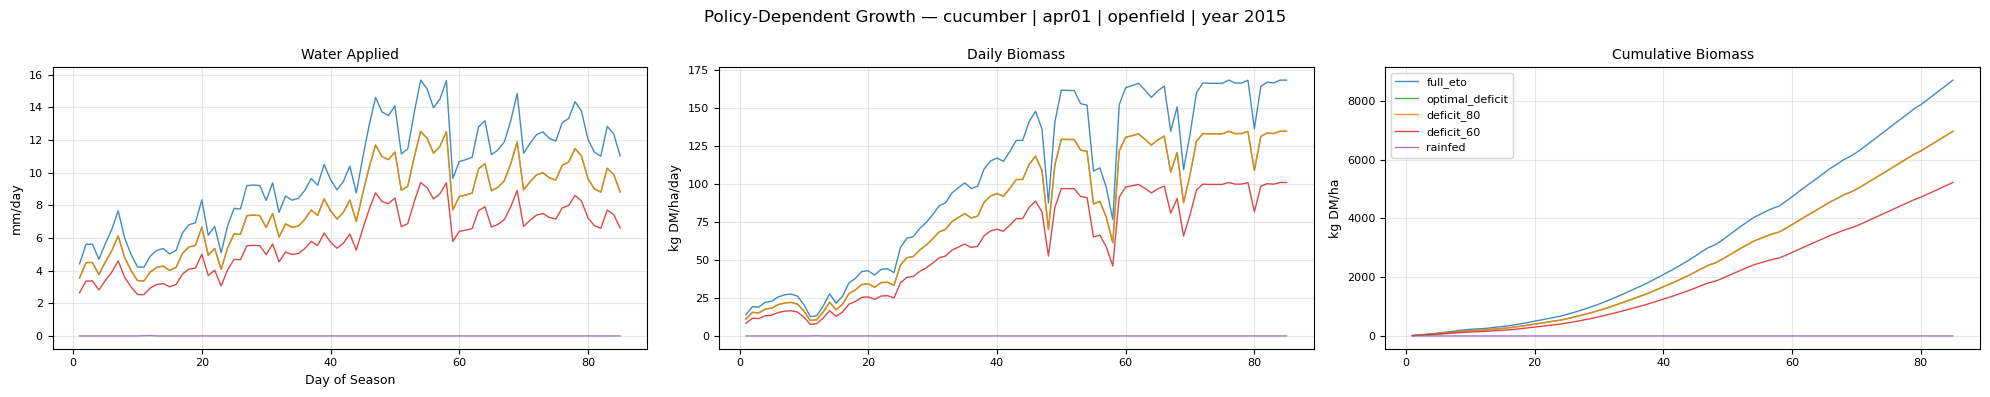

In [5]:
# Row 2 — policy-dependent variables (irrigation policies overlaid)
ROW2_VARS = [
    ("water_applied_mm",        "mm/day",        "Water Applied"),
    ("biomass_kg_ha",           "kg DM/ha/day",  "Daily Biomass"),
    ("cumulative_biomass_kg_ha", "kg DM/ha",     "Cumulative Biomass"),
]

fig, axes = plt.subplots(1, len(ROW2_VARS), figsize=(20, 4), sharex=True)
for ax, (col, ylabel, title) in zip(axes, ROW2_VARS):
    for policy in policies:
        sub = df[df["irrigation_policy"] == policy]
        ax.plot(sub["day_of_season"], sub[col],
                color=color_for(policy), label=policy, alpha=0.85, linewidth=1.0)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.set_title(title, fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

axes[-1].legend(loc="upper left", fontsize=8, ncol=1)
axes[0].set_xlabel("Day of Season", fontsize=9)
fig.suptitle(
    f"Policy-Dependent Growth — {CROP} | {PLANTING} | {CONDITION} | year {WEATHER_YEAR}",
    fontsize=12,
)
plt.tight_layout()
plt.show()

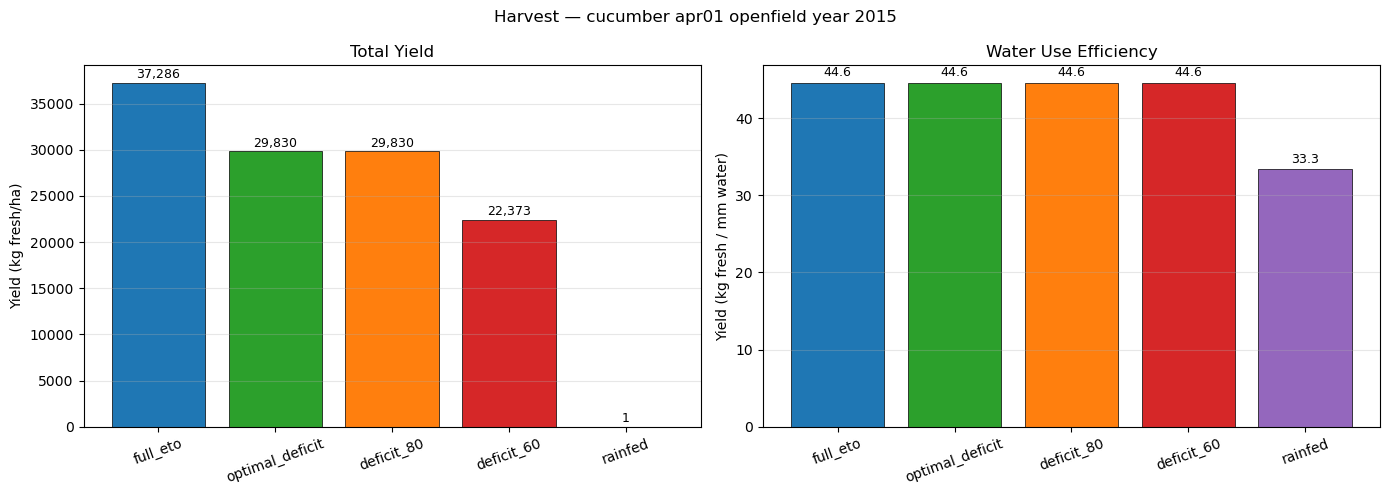

                   yield_fresh_kg_ha  total_water_mm  yield_per_mm
irrigation_policy                                                 
full_eto                     37286.0           836.1          44.6
optimal_deficit              29830.0           668.9          44.6
deficit_80                   29830.0           668.9          44.6
deficit_60                   22373.0           501.7          44.6
rainfed                          1.0             0.0          33.3


In [6]:
# Harvest yield + water use efficiency by irrigation policy
harvest = df[df["day_of_season"] == season_len][["irrigation_policy", "yield_fresh_kg_ha"]].copy()
total_water = df.groupby("irrigation_policy")["water_applied_mm"].sum()
harvest = harvest.set_index("irrigation_policy")
harvest["total_water_mm"] = total_water
harvest["yield_per_mm"] = harvest["yield_fresh_kg_ha"] / harvest["total_water_mm"].replace(0, float("nan"))
harvest = harvest.reindex(policies)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left — total yield
bars1 = ax1.bar(harvest.index, harvest["yield_fresh_kg_ha"],
                color=[color_for(p) for p in harvest.index], edgecolor="black", linewidth=0.5)
for bar, val in zip(bars1, harvest["yield_fresh_kg_ha"]):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 200,
             f"{val:,.0f}", ha="center", va="bottom", fontsize=9)
ax1.set_ylabel("Yield (kg fresh/ha)")
ax1.set_title("Total Yield")
ax1.grid(axis="y", alpha=0.3)
ax1.tick_params(axis="x", rotation=20)

# Right — yield per mm water
bars2 = ax2.bar(harvest.index, harvest["yield_per_mm"],
                color=[color_for(p) for p in harvest.index], edgecolor="black", linewidth=0.5)
for bar, val in zip(bars2, harvest["yield_per_mm"]):
    if pd.notna(val):
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f"{val:.1f}", ha="center", va="bottom", fontsize=9)
    else:
        ax2.text(bar.get_x() + bar.get_width() / 2, 0.5,
                 "n/a", ha="center", va="bottom", fontsize=9, color="gray")
ax2.set_ylabel("Yield (kg fresh / mm water)")
ax2.set_title("Water Use Efficiency")
ax2.grid(axis="y", alpha=0.3)
ax2.tick_params(axis="x", rotation=20)

fig.suptitle(
    f"Harvest — {CROP} {PLANTING} {CONDITION} year {WEATHER_YEAR}", fontsize=12,
)
plt.tight_layout()
plt.show()

print(harvest.round(1).to_string())

In [7]:
# Season summary statistics per policy
summary_cols = ["eto_mm", "etc_mm", "water_applied_mm", "water_stress_coeff",
                "temp_stress_coeff", "biomass_kg_ha"]

summary = df.groupby("irrigation_policy")[summary_cols].agg(["mean", "sum"]).round(1)
summary = summary.reindex(policies)
summary

eto_mm        etc_mm        water_applied_mm         \
                    mean    sum   mean    sum             mean    sum   
irrigation_policy                                                       
full_eto            11.5  979.8    9.8  836.0              9.8  836.1   
optimal_deficit     11.5  979.8    9.8  836.0              7.9  668.9   
deficit_80          11.5  979.8    9.8  836.0              7.9  668.9   
deficit_60          11.5  979.8    9.8  836.0              5.9  501.7   
rainfed             11.5  979.8    9.8  836.0              0.0    0.0   

                  water_stress_coeff       temp_stress_coeff        \
                                mean   sum              mean   sum   
irrigation_policy                                                    
full_eto                         1.0  85.0               0.9  79.2   
optimal_deficit                  0.8  68.0               0.9  79.2   
deficit_80                       0.8  68.0               0.9  79.2   
deficit_60                       0.6  51.0               0.9  79.2   
rainfed                          0.0   0.0               0.9  79.2   

                  biomass_kg_ha          
                           mean     sum  
irrigation_policy                        
full_eto                  102.5  8710.6  
optimal_deficit            82.0  6969.0  
deficit_80                 82.0  6969.0  
deficit_60                 61.5  5226.0  
rainfed                     0.0     0.1